# Scaling vs Logistic Regression: experiment

This notebook compares logistic regression pipelines with different scalers on a real dataset. Adjust the config cell to switch datasets or inject outliers.

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn components
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, log_loss, confusion_matrix

# Ensure repeatable randomness for the demo
np.random.seed(42)

# Config
DATASET_NAME = "breast_cancer"  # "breast_cancer" or "wine"
INJECT_OUTLIERS = True          # set True to emphasize RobustScaler benefits
USE_MINMAX = True               # include MinMaxScaler pipeline
TEST_SIZE = 0.2
RANDOM_STATE = 42

## Data loading and split

We load the dataset, optionally inject outliers to stress-test scaling, and create a stratified train/test split.

In [2]:
# Load a real dataset and return task metadata
def load_dataset(name: str):
    # Pick dataset and define task type for metrics
    if name == "breast_cancer":
        data = load_breast_cancer()
        task = "binary"
    elif name == "wine":
        data = load_wine()
        task = "multiclass"
    else:
        raise ValueError("Unknown dataset name")

    # Extract arrays and feature names in a consistent format
    X = data.data.astype(float)
    y = data.target
    feature_names = data.feature_names
    target_names = getattr(data, "target_names", None)
    return X, y, feature_names, target_names, task


# Inject outliers to stress-test scalers (optional)
def inject_outliers(X: np.ndarray, frac: float = 0.01, magnitude: float = 10.0):
    X_out = X.copy()
    n_rows, n_cols = X_out.shape
    n_out = max(1, int(n_rows * frac))
    rows = np.random.choice(n_rows, size=n_out, replace=False)
    cols = np.random.choice(n_cols, size=2, replace=True)

    # Add large spikes to a small subset of features
    for c in cols:
        X_out[rows, c] = X_out[rows, c] + magnitude * X_out[:, c].std()
    return X_out


# Load dataset
X, y, feature_names, target_names, task = load_dataset(DATASET_NAME)
if INJECT_OUTLIERS:
    X = inject_outliers(X, frac=0.02, magnitude=12.0)

# Train/test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Dataset: {DATASET_NAME} | Task: {task} | Train size: {X_train.shape} | Test size: {X_test.shape}")

Dataset: breast_cancer | Task: binary | Train size: (455, 30) | Test size: (114, 30)


## Housekeeping

Minor settings to keep output clean while experimenting.

In [ ]:
import warnings

# Keep output tidy during repeated experiments
warnings.filterwarnings("ignore")

## Pipelines and evaluation

We build the scaling pipelines, train them, and log accuracy, AUC or macro-F1, log loss, confusion matrices, coefficient norms, and transform diagnostics.

In [5]:
# Compare percentile shifts between train and test after transformation
def percentile_drift(X_tr: np.ndarray, X_te: np.ndarray, perc=(5, 50, 95)) -> float:
    p_tr = np.percentile(X_tr, perc, axis=0)
    p_te = np.percentile(X_te, perc, axis=0)
    return float(np.mean(np.abs(p_tr - p_te)))


# Build pipelines for different scaling strategies
def build_pipelines(task_type: str, use_minmax: bool):
    # Base classifier shared across pipelines for fair comparison
    base_lr = LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE,
        solver="lbfgs",
        multi_class="auto",
    )

    pipelines = [
        (
            "no_scaling",
            Pipeline(
                [
                    # Identity transform to keep a consistent pipeline structure
                    ("scaler", FunctionTransformer(lambda x: x, feature_names_out="one-to-one")),
                    ("clf", base_lr),
                ]
            ),
        ),
        (
            "standard_scaler",
            Pipeline([("scaler", StandardScaler()), ("clf", base_lr)]),
        ),
        (
            "robust_scaler",
            Pipeline([("scaler", RobustScaler()), ("clf", base_lr)]),
        ),
    ]

    # Optional MinMaxScaler with clipping to highlight out-of-range effects
    if use_minmax:
        pipelines.append(
            (
                "minmax_scaler",
                Pipeline(
                    [
                        ("scaler", MinMaxScaler(feature_range=(0, 1), clip=True)),
                        ("clf", base_lr),
                    ]
                ),
            )
        )

    return pipelines


# Fit a pipeline and compute metrics + diagnostics
def evaluate_pipeline(name, pipeline, X_tr, y_tr, X_te, y_te, task_type):
    # Train and predict
    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_te)
    y_proba = pipeline.predict_proba(X_te)
    
    # Core metrics
    acc = accuracy_score(y_te, y_pred)
    if task_type == "binary":
        auc = roc_auc_score(y_te, y_proba[:, 1])
        f1 = None
        ll = log_loss(y_te, y_proba[:, 1])
    else:
        auc = None
        f1 = f1_score(y_te, y_pred, average="macro")
        ll = log_loss(y_te, y_proba)

    # Confusion matrix and coefficient norm for regularization effects
    cm = confusion_matrix(y_te, y_pred)
    coef_norm = float(np.linalg.norm(pipeline.named_steps["clf"].coef_))

    # Transformation diagnostics
    scaler = pipeline.named_steps["scaler"]
    X_tr_t = scaler.transform(X_tr)
    X_te_t = scaler.transform(X_te)

    train_mean = float(np.mean(X_tr_t))
    train_std = float(np.std(X_tr_t))
    drift = percentile_drift(X_tr_t, X_te_t)

    # MinMax clipping counts (if enabled)
    clip_count = None
    if isinstance(scaler, MinMaxScaler):
        below = X_te < scaler.data_min_
        above = X_te > scaler.data_max_
        clip_count = int(np.sum(below | above))

    result = {
        "pipeline": name,
        "accuracy": acc,
        "roc_auc": auc,
        "macro_f1": f1,
        "log_loss": ll,
        "coef_norm": coef_norm,
    }
    diag = {
        "pipeline": name,
        "train_mean": train_mean,
        "train_std": train_std,
        "percentile_drift": drift,
        "clip_count": clip_count,
    }

    return result, diag, cm, X_tr_t, X_te_t, pipeline


# Build pipelines and run evaluation
pipelines = build_pipelines(task, USE_MINMAX)

results = []
diagnostics = []
conf_mats = {}
transformed = {}
models = {}

for name, pipe in pipelines:
    res, diag, cm, X_tr_t, X_te_t, fitted = evaluate_pipeline(
        name, pipe, X_train, y_train, X_test, y_test, task
    )
    results.append(res)
    diagnostics.append(diag)
    conf_mats[name] = cm
    transformed[name] = (X_tr_t, X_te_t)
    models[name] = fitted

# Tabular summaries for quick comparison
results_df = pd.DataFrame(results)
diagnostics_df = pd.DataFrame(diagnostics)

results_df

,pipeline,accuracy,roc_auc,macro_f1,log_loss,coef_norm
0,no_scaling,0.964912,0.995370,None,0.089840,2.371701
1,standard_scaler,0.973684,0.995701,None,0.077725,3.649865
2,robust_scaler,0.973684,0.996362,None,0.077564,3.855885
3,minmax_scaler,0.956140,0.995701,None,0.143863,7.142241


## Error analysis

We inspect false positives vs false negatives, check errors at feature extremes, and compare coefficient magnitudes across pipelines.

In [6]:
# Error analysis utilities
def error_analysis(pipeline, X_tr, y_tr, X_te, y_te, feature_names, task_type):
    # Get predictions and probabilities
    y_pred = pipeline.predict(X_te)
    y_proba = pipeline.predict_proba(X_te)

    # Overall errors and binary-specific FP/FN counts
    errors = y_pred != y_te
    fp = int(np.sum((y_pred == 1) & (y_te == 0))) if task_type == "binary" else None
    fn = int(np.sum((y_pred == 0) & (y_te == 1))) if task_type == "binary" else None

    # Feature extremes using train percentiles (raw space)
    low = np.percentile(X_tr, 1, axis=0)
    high = np.percentile(X_tr, 99, axis=0)
    extreme_mask = (X_te < low) | (X_te > high)
    extreme_errors = int(np.sum(errors & np.any(extreme_mask, axis=1)))
    error_count = int(np.sum(errors))
    extreme_error_rate = (extreme_errors / error_count) if error_count > 0 else 0.0

    # Simple calibration check by comparing average probabilities
    if task_type == "binary":
        mean_pos_prob = float(np.mean(y_proba[y_te == 1, 1]))
        mean_neg_prob = float(np.mean(y_proba[y_te == 0, 1]))
    else:
        true_class_prob = y_proba[np.arange(len(y_te)), y_te]
        mean_pos_prob = float(np.mean(true_class_prob))
        mean_neg_prob = None

    # Coefficient magnitudes to spot dominance without scaling
    coef = pipeline.named_steps["clf"].coef_
    if task_type == "binary":
        coef_abs = np.abs(coef[0])
    else:
        coef_abs = np.mean(np.abs(coef), axis=0)

    top_idx = np.argsort(coef_abs)[-5:][::-1]
    top_features = pd.DataFrame(
        {
            "feature": [feature_names[i] for i in top_idx],
            "abs_coef": coef_abs[top_idx],
        }
    )

    return {
        "false_pos": fp,
        "false_neg": fn,
        "error_count": error_count,
        "extreme_error_rate": extreme_error_rate,
        "mean_pos_prob": mean_pos_prob,
        "mean_neg_prob": mean_neg_prob,
    }, top_features


# Run error analysis for each pipeline
analysis_rows = []
coef_tables = {}

for name, model in models.items():
    row, top_features = error_analysis(
        model, X_train, y_train, X_test, y_test, feature_names, task
    )
    row["pipeline"] = name
    analysis_rows.append(row)
    coef_tables[name] = top_features

analysis_df = pd.DataFrame(analysis_rows)
analysis_df

,false_pos,false_neg,error_count,extreme_error_rate,mean_pos_prob,mean_neg_prob,pipeline
0,0,72,72,0.236111,0.000000,0.000000,no_scaling
1,5,0,5,0.400000,0.999597,0.120705,standard_scaler
2,4,1,5,0.400000,0.985028,0.084698,robust_scaler
3,4,1,5,0.400000,0.877911,0.109366,minmax_scaler


## Tables and confusion matrices

Tabular summaries of results and per-pipeline confusion matrices make the comparisons easy to scan.

In [7]:
# Display all tables for quick review
display(results_df)
display(diagnostics_df)
display(analysis_df)

# Confusion matrices per pipeline
for name, cm in conf_mats.items():
    print(f"Confusion matrix: {name}")
    display(pd.DataFrame(cm))

# Top coefficients to compare scaling impacts
print("Top coefficient magnitudes by pipeline")
for name, df in coef_tables.items():
    print(name)
    display(df)

,pipeline,accuracy,roc_auc,macro_f1,log_loss,coef_norm
0,no_scaling,0.964912,0.995370,None,0.089840,2.371701
1,standard_scaler,0.973684,0.995701,None,0.077725,3.649865
2,robust_scaler,0.973684,0.996362,None,0.077564,3.855885
3,minmax_scaler,0.956140,0.995701,None,0.143863,7.142241


,pipeline,train_mean,train_std,percentile_drift,clip_count
0,no_scaling,6.121416e+01,224.609861,1.785213,NaN
1,standard_scaler,-1.873959e-17,1.000000,0.142285,NaN
2,robust_scaler,2.224674e-01,0.979670,0.135432,NaN
3,minmax_scaler,2.323462e-01,0.176662,0.019497,10.0


,false_pos,false_neg,error_count,extreme_error_rate,mean_pos_prob,mean_neg_prob,pipeline
0,0,72,72,0.236111,0.000000,0.000000,no_scaling
1,5,0,5,0.400000,0.999597,0.120705,standard_scaler
2,4,1,5,0.400000,0.985028,0.084698,robust_scaler
3,4,1,5,0.400000,0.877911,0.109366,minmax_scaler


Confusion matrix: no_scaling


,0,1
0,39,3
1,1,71


Confusion matrix: standard_scaler


,0,1
0,41,1
1,2,70


Confusion matrix: robust_scaler


,0,1
0,41,1
1,2,70


Confusion matrix: minmax_scaler


,0,1
0,38,4
1,1,71


Top coefficient magnitudes by pipeline
no_scaling


,feature,abs_coef
0,worst concave points,2.623341
1,worst radius,2.347771
2,worst perimeter,2.176109
3,worst texture,2.118561
4,mean concave points,1.989314


standard_scaler


,feature,abs_coef
0,worst concave points,2.623341
1,worst radius,2.347771
2,worst perimeter,2.176109
3,worst texture,2.118561
4,mean concave points,1.989314


robust_scaler


,feature,abs_coef
0,worst concave points,2.623341
1,worst radius,2.347771
2,worst perimeter,2.176109
3,worst texture,2.118561
4,mean concave points,1.989314


minmax_scaler


,feature,abs_coef
0,worst concave points,2.623341
1,worst radius,2.347771
2,worst perimeter,2.176109
3,worst texture,2.118561
4,mean concave points,1.989314


## Visualizations

Charts for metric comparisons, diagnostics, coefficient norms, and confusion matrices.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

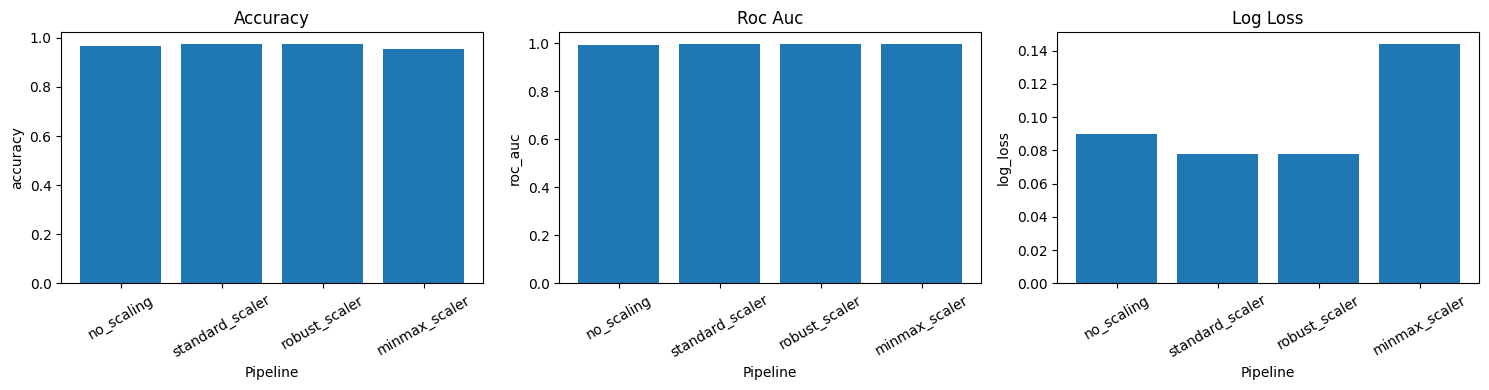

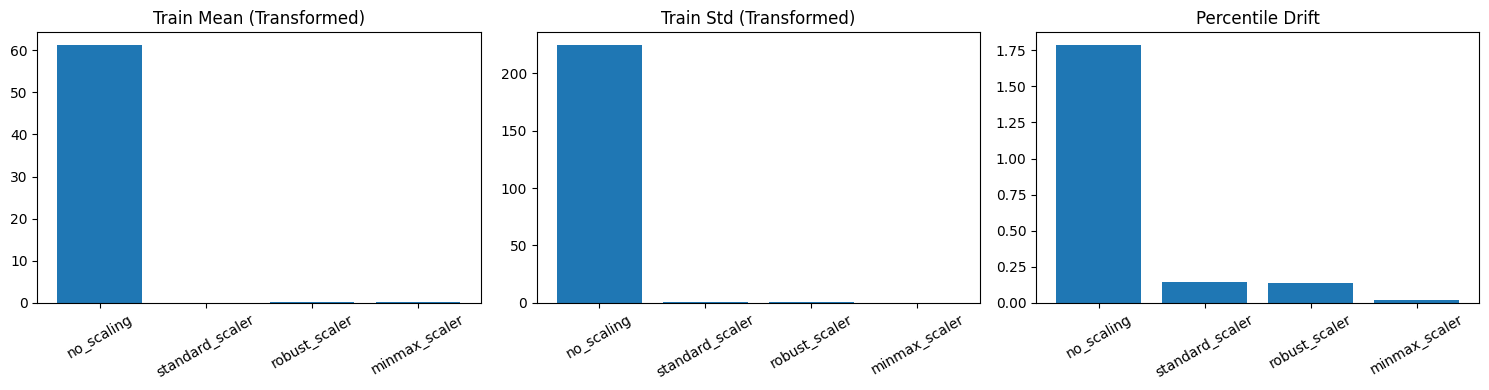

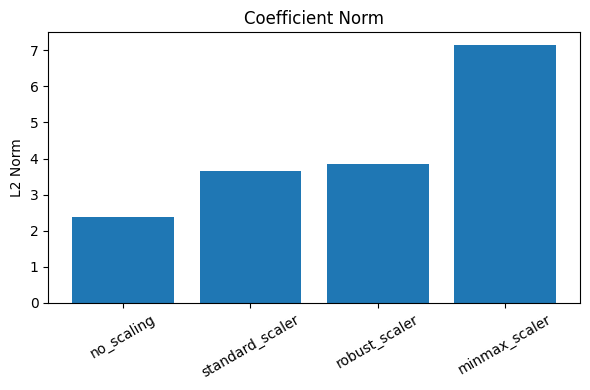

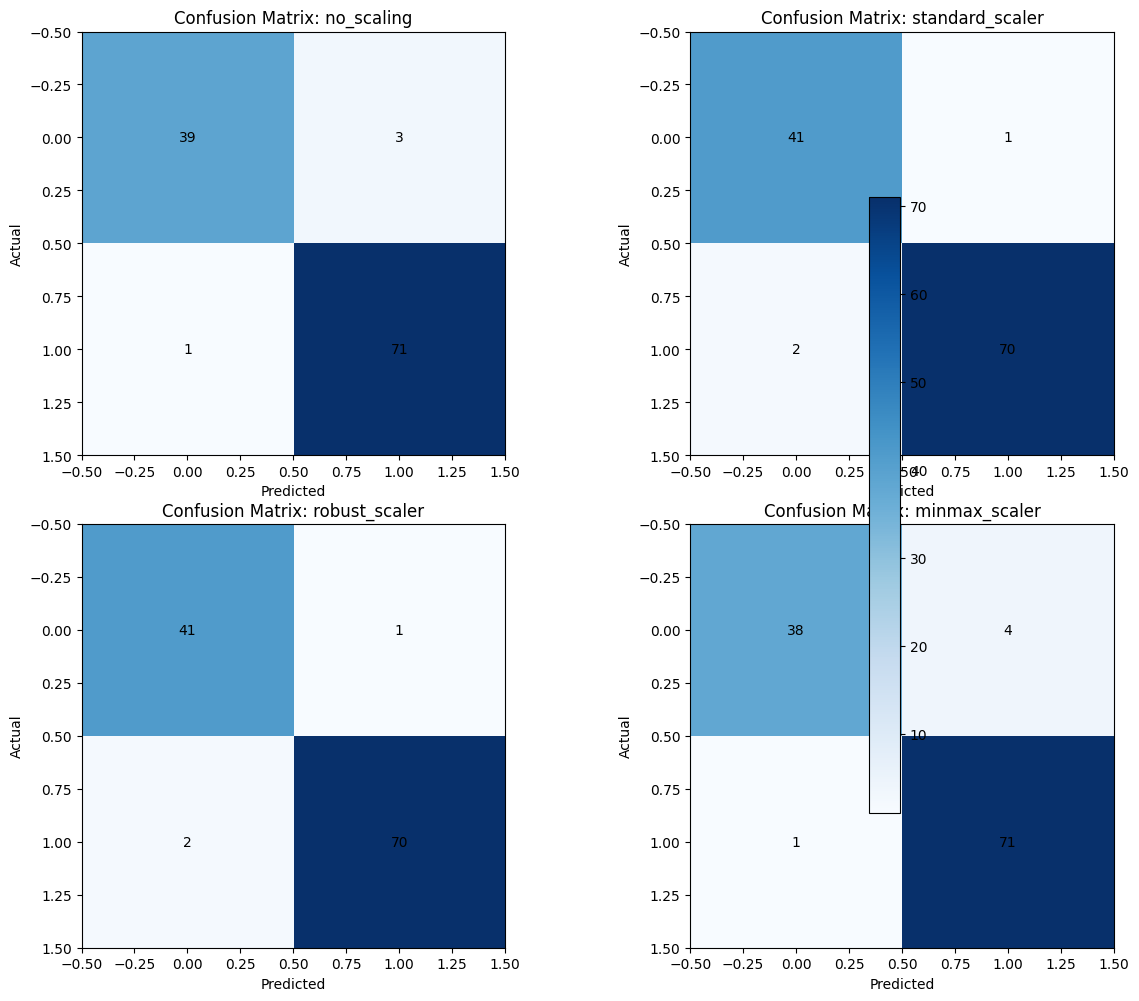

In [10]:
# -----------------------------
# Visualizations
# -----------------------------

# Select metric columns based on task
plot_df = results_df.copy()
if task == "binary":
    metric_cols = ["accuracy", "roc_auc", "log_loss"]
else:
    metric_cols = ["accuracy", "macro_f1", "log_loss"]

# Bar charts for core metrics
fig, axes = plt.subplots(1, len(metric_cols), figsize=(5 * len(metric_cols), 4))
if len(metric_cols) == 1:
    axes = [axes]

for ax, metric in zip(axes, metric_cols):
    ax.bar(plot_df["pipeline"], plot_df[metric])
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Pipeline")
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# Diagnostics: train mean/std and drift
diag_plot = diagnostics_df.copy()
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].bar(diag_plot["pipeline"], diag_plot["train_mean"])
axes[0].set_title("Train Mean (Transformed)")
axes[0].tick_params(axis="x", rotation=30)

axes[1].bar(diag_plot["pipeline"], diag_plot["train_std"])
axes[1].set_title("Train Std (Transformed)")
axes[1].tick_params(axis="x", rotation=30)

axes[2].bar(diag_plot["pipeline"], diag_plot["percentile_drift"])
axes[2].set_title("Percentile Drift")
axes[2].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

# Coefficient norm comparison
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(plot_df["pipeline"], plot_df["coef_norm"])
ax.set_title("Coefficient Norm")
ax.set_ylabel("L2 Norm")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

# Confusion matrices as heatmaps
n = len(conf_mats)
cols = min(2, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = np.array(axes).reshape(-1)

for ax, (name, cm) in zip(axes, conf_mats.items()):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix: {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha="center", va="center", color="black")

# Hide any unused subplot axes
for ax in axes[len(conf_mats) :]:
    ax.axis("off")

fig.colorbar(im, ax=axes[: len(conf_mats)], shrink=0.8)
plt.tight_layout()
plt.show()